In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
# from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mvn
%matplotlib inline

In [6]:
f = 'https://raw.githubusercontent.com/BlackArbsCEO/Mixture_Models/K-Means%2C-E-M%2C-Mixture-Models/Class_heights.csv'

data = pd.read_csv(f)
# data.info()

height = data['Height (in)']
data

,Gender,Height (in)
0,Male,72
1,Male,72
2,Female,63
3,Female,62
4,Female,62
5,Male,73
6,Female,64
7,Female,63
8,Female,67
9,Male,71


In [2]:
# Code sourced from:
#    http://people.duke.edu/~ccc14/sta-663/EMAlgorithm.html

def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        print('\nIteration: ', i)
        print()
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()
        
        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        new_mus = (np.diag(mus)[0], np.diag(mus)[1])
        new_sigs = (np.unique(np.diag(sigmas[0]))[0], np.unique(np.diag(sigmas[1]))[0])
        df = (pd.DataFrame(index=[1, 2]).assign(mus = new_mus).assign(sigs = new_sigs))
        
        xx = np.linspace(0, 100, 100)
        yy = scs.multivariate_normal.pdf(xx, mean=new_mus[0], cov=new_sigs[0])
        
        colors = sns.color_palette('Dark2', 3)
        fig, ax = plt.subplots(figsize=(9, 7))
        ax.set_ylim(-0.001, np.max(yy))
        ax.plot(xx, yy, color=colors[1])
        ax.axvline(new_mus[0], ymin=0., color=colors[1])
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[1])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_1$: {new_mus[0]:3.2f}', 
                    fontsize=12, fontweight='demi',
                    xy=(new_mus[0], (hi-lo) / 2), 
                    xycoords='data', xytext=(80, (hi-lo) / 2),
                    arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy, alpha=0.5, color=colors[2])
        
        yy2 = scs.multivariate_normal.pdf(xx, mean=new_mus[1], cov=new_sigs[1])
        
        ax.plot(xx, yy2, color=colors[2])
        ax.axvline(new_mus[1], ymin=0., color=colors[2])
        lo, hi = ax.get_ylim()
        ax.annotate(f'$\mu_2$: {new_mus[1]:3.2f}', 
                    fontsize=12, fontweight='demi',
            xy=(new_mus[1], (hi-lo) / 2), xycoords='data', xytext=(25, (hi-lo) / 2),
            arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2",shrink=0.05))
        ax.fill_between(xx, 0, yy2, alpha=0.5, color=colors[2])
        
        dot_kwds = dict(markerfacecolor='white', markeredgecolor='black', markeredgewidth=1, markersize=10)
        ax.plot(height, len(height)*[0], 'o', **dot_kwds)
        ax.set_ylim(-0.001, np.max(yy2))
        
        
        print(df.T)   
        
        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)
        print(f'log_likelihood: {ll_new:3.4f}')
        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new
        
    return ll_new, pis, mus, sigmas


Iteration:  0

               1           2
mus    61.362928   59.659685
sigs  469.240750  244.382352
log_likelihood: -141.8092

Iteration:  1

              1          2
mus    68.73773  63.620554
sigs  109.85442   7.228183
log_likelihood: -118.0520

Iteration:  2

              1          2
mus   70.569842  63.688825
sigs   4.424452   3.139277
log_likelihood: -100.2591

Iteration:  3

              1          2
mus   70.569842  63.688825
sigs   4.424427   3.139278
log_likelihood: -100.2591


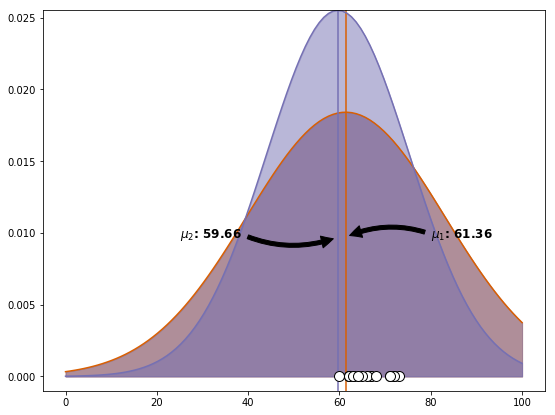

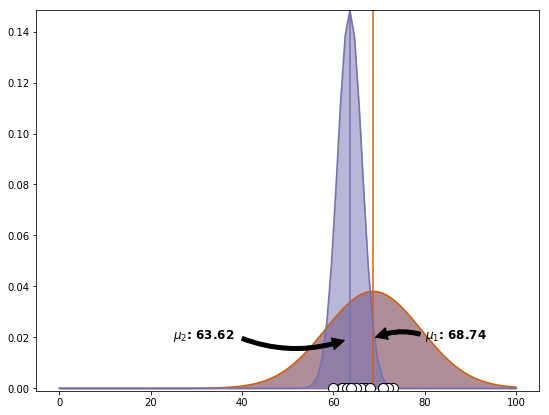

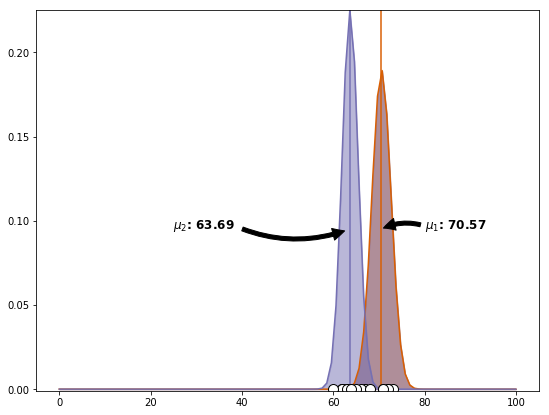

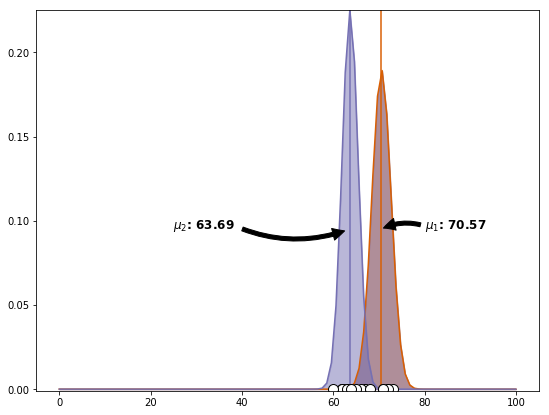

In [12]:
import seaborn as sns
height = data['Height (in)']
n = len(height)

# Ground truthish
_mus = np.array([[0, data.groupby('Gender').mean().iat[0, 0]], 
                 [data.groupby('Gender').mean().iat[1, 0], 0]])
_sigmas = np.array([[[5, 0], [0, 5]], 
                    [[5, 0],[0, 5]]])
_pis = np.array([0.5, 0.5]) # priors

# initial random guesses for parameters
np.random.seed(0)

pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2) * height.std()

# generate our noisy x values
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

ll, pis, mus, sigmas = em_gmm_orig(xs, pis, mus, sigmas)

# In the below plots the white dots represent the observed heights.